In [1]:
import os
import json
import cv2
import pickle
from tqdm import tqdm

import torch
import random
import numpy as np
from matplotlib import pyplot as plt
from pose_data import PoseGraph
from training import Trainer, Logger
from torch.utils.data import DataLoader

In [2]:
#from gpec_models.gcae import GCAE
from nf_models.model_pose import STG_NF
from nf_models.graph import Graph
#model.load_state_dict(torch.load('checkpoints/ShanghaiTech_85_9.tar')['state_dict'])
from vae import VAE, vae_loss, ae_loss

In [3]:
#83 , 1.21 sec/itr

In [4]:
args = {
'exp_name'    : 'exp-arch-3_99-1',
'no_of_files' : 330,
'channel'     : 2,
'seg_len'     : 24,
'no_of_kps'   : 18,
'seg_stride'  : 1,
'train_stride': 30,#30
'seg_conf_thr': 0,
'seed'        : 0,
'lr'          : 0.000001,
'bsize'       : 256,
'device'      : 'cuda:0',
'hdims'       : [9,9],
'num_heads'   :  1,
'num_embd_lyrs': 1,
'num_deep_lyrs': 1,
'latent_dim'   : 128,
'ksize'       : 3,
'vid_res'     : [856, 480],
'json_dir'    : {
    'train' : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/pose/train', 
    'valid' : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/pose/test' 
},
'gt_dir'      : {
    'valid'    :
    {
    'mask_dir'  : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test/test_frame_mask/',
    'frame_dir' : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test/frames/'
    },
    'train'    :
    {
    'mask_dir'  : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/train/train_frame_mask/',
    'frame_dir' : '/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/train/frames/'
    }
}
}

'''
train_dataset = PoseGraph(args,split='train')
valid_dataset = PoseGraph(args,split='valid')

with open('st_data.pkl','wb') as file:
    pickle.dump([train_dataset,valid_dataset],file)
''' 
with open('st_data.pkl','rb') as file:
    [train_dataset,valid_dataset] = pickle.load(file)
    
train_loader  = DataLoader(train_dataset,args['bsize'])
valid_loader  = DataLoader(valid_dataset,args['bsize'])

#model = STG_NF()
#model = GCAE(in_channels=3)
model   = VAE(args,2,hidden_dims=args['hdims'])#[24,48,96,192]

trainer = Trainer(model,
                  train_loader,
                  valid_loader,
                  loss_func = vae_loss,#stg_nf_loss,#ae_loss,#model.loss_function,
                  epochs    = 5,
                  lr        = args['lr'])


In [5]:
model

VAE(
  (encoder): ModuleList(
    (0): StGcn(
      (layer_embd): ModuleList(
        (0): Sequential(
          (0): Conv2d(2, 9, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
          (1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (conv_qry): ModuleList(
        (0): Conv2d(9, 9, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_key): ModuleList(
        (0): Conv2d(9, 9, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_exp): ModuleList()
      (conv_val): ModuleList(
        (0): Conv2d(9, 9, kernel_size=(1, 1), stride=(1, 1))
      )
      (layer_deep): ModuleList(
        (0): Sequential(
          (0): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (1): StGcn(
      (residual): Sequential(
        (0): Conv2d(9, 9, kernel_size=(1, 1), stride=(1,

In [6]:
from score import Score
scr = Score(path='/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test/test_frame_mask/')
lgr = Logger(keys=['train_loss','val_acc'], exp_name=args['exp_name'])
lgr.save_src()
lgr.save_args(args)
model.to(args['device'])
for epoch in range(20):
    state_dict     = trainer.train(lgr=lgr)
    tscore ,_,_,_  = trainer.test()
    auc,_ = scr.score_dataset(tscore,valid_dataset.meta_data)
    lgr.update({'val_acc':auc})
    lgr.accumulate(epoch,state_dict)
    print(lgr.log_df.tail(1))
    lgr.save_logs()

  1%|▎                                          | 4/566 [00:00<00:17, 32.40it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:18<00:00, 31.37it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 976.16it/s]
rm: cannot remove '{self.model_dir}*': No such file or directory


    train_loss   val_acc
0  1343608.875  0.805865


  1%|▎                                          | 4/566 [00:00<00:14, 38.48it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:15<00:00, 36.25it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 956.72it/s]


  train_loss   val_acc
1    0.68196  0.770057


  1%|▎                                          | 4/566 [00:00<00:16, 33.94it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:18<00:00, 31.25it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 872.84it/s]
rm: cannot remove '{self.model_dir}*': No such file or directory


  train_loss   val_acc
2   0.235205  0.824896


  1%|▏                                          | 3/566 [00:00<00:21, 26.56it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:20<00:00, 28.15it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 759.81it/s]
rm: cannot remove '{self.model_dir}*': No such file or directory


  train_loss   val_acc
3    0.17007  0.834096


  1%|▏                                          | 3/566 [00:00<00:21, 26.28it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:20<00:00, 27.98it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 720.83it/s]


  train_loss   val_acc
4   0.166749  0.833766


  1%|▏                                          | 3/566 [00:00<00:22, 25.00it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:21<00:00, 25.75it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 694.15it/s]


  train_loss   val_acc
5   0.145508  0.830166


  1%|▏                                          | 3/566 [00:00<00:21, 25.65it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:19<00:00, 29.37it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 369.22it/s]
rm: cannot remove '{self.model_dir}*': No such file or directory


  train_loss   val_acc
6   0.169669  0.836816


  1%|▏                                          | 3/566 [00:00<00:22, 24.65it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:19<00:00, 28.50it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 599.25it/s]


  train_loss   val_acc
7   0.143182  0.835933


  1%|▏                                          | 3/566 [00:00<00:23, 24.37it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:22<00:00, 24.80it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 731.50it/s]
rm: cannot remove '{self.model_dir}*': No such file or directory


  train_loss   val_acc
8   0.149665  0.840819


  1%|▏                                          | 3/566 [00:00<00:25, 22.51it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:24<00:00, 22.96it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 730.65it/s]


  train_loss   val_acc
9    0.14262  0.828655


  1%|▏                                          | 3/566 [00:00<00:27, 20.56it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:25<00:00, 22.44it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 724.30it/s]


   train_loss   val_acc
10   0.130002  0.830727


  0%|▏                                          | 2/566 [00:00<00:29, 19.22it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:26<00:00, 21.08it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 544.44it/s]


   train_loss   val_acc
11   0.123614  0.831562


  1%|▏                                          | 3/566 [00:00<00:26, 21.60it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:28<00:00, 20.16it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 345.63it/s]


   train_loss   val_acc
12   0.119675  0.830096


  0%|▏                                          | 2/566 [00:00<00:33, 16.62it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:30<00:00, 18.30it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 456.77it/s]


   train_loss   val_acc
13   0.115735  0.825908


  0%|▏                                          | 2/566 [00:00<00:29, 19.12it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:33<00:00, 17.04it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 277.71it/s]


   train_loss   val_acc
14   0.112778  0.831518


  0%|▏                                          | 2/566 [00:00<00:28, 19.93it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:30<00:00, 18.68it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 419.08it/s]


   train_loss   val_acc
15   0.123806  0.837199


  0%|▏                                          | 2/566 [00:00<00:33, 16.85it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:30<00:00, 18.42it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 429.93it/s]


   train_loss   val_acc
16    0.11959  0.830204


  0%|▏                                          | 2/566 [00:00<00:40, 13.96it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:34<00:00, 16.18it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 528.12it/s]


   train_loss   val_acc
17   0.114825  0.831895


  0%|▏                                          | 2/566 [00:00<00:31, 17.96it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:36<00:00, 15.63it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 509.09it/s]


   train_loss   val_acc
18    0.11075  0.830001


  0%|▏                                          | 2/566 [00:00<00:39, 14.45it/s]

Starting Test Eval


100%|█████████████████████████████████████████| 566/566 [00:34<00:00, 16.30it/s]


Scoring 107 clips


100%|████████████████████████████████████████| 107/107 [00:00<00:00, 427.87it/s]


     train_loss   val_acc
19  839325.0625  0.788827


In [7]:
import pandas as pd
df_1 = pd.read_csv('logs/exp-arch-1_9/results.csv')
#df_2 = pd.read_csv('logs/exp-arch-3_4/results.csv')
df_2 = pd.read_csv('logs/exp-arch-3_9/results.csv')
df_3 = pd.read_csv('logs/exp-arch-3_99/results.csv')
#df_3 = pd.read_csv('logs/exp-arch-5_9/results.csv')
#df_5 = pd.read_csv('logs/exp-arch-3_16/results.csv')
#df_4 = pd.read_csv('logs/exp-arch-7_9/results.csv')

In [8]:
with open('logs/exp-arch-3_16/args.json') as f:
    arg = json.load(f)
arg['ksize'],arg['hdims']

(3, [16, 2])

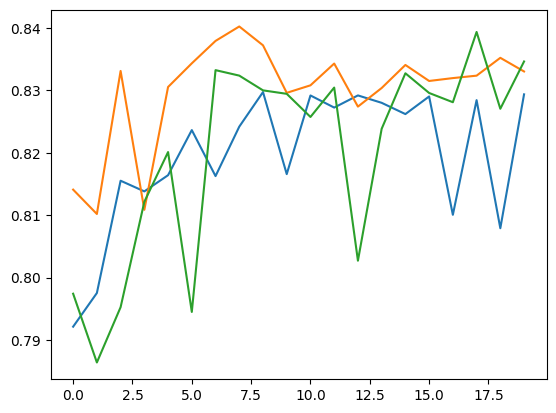

In [9]:
plt.plot(df_1['val_acc'])
plt.plot(df_2['val_acc'])
plt.plot(df_3['val_acc'])
#plt.plot(df_4['val_acc'])
#plt.plot(df_5['val_acc'])

In [10]:
train_loss   val_acc
10   0.126995  0.823339
11   0.123757  0.823653
12   0.121868  0.824856
13   0.119379  0.823649
14   0.117477  0.825782
15   0.116145  0.827569
16   0.115601  0.826698
17   0.113144  0.826345
18   0.111893   0.82757
19   0.110345  0.827979

SyntaxError: invalid syntax (3107218633.py, line 1)

In [ ]:
model

In [ ]:
model.encoder[0].adjs[0]

In [ ]:
#model = VAE(args,2,128,hidden_dims=[18,36,36,72])#[24,48,96,192]
#model.load_state_dict(torch.load('Jan31_2034__checkpoint.pth.tar')['state_dict'])
#model.load_state_dict(torch.load('logs/exp-arch-8/model/2_exp-arch-8_0.83.pth')['state_dict'])

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(20,4))
for i in range(2):
    axes[i].imshow(model.encoder[i].adjs[0].detach().cpu().numpy(),cmap='plasma')

In [ ]:
torch.nn.Softmax(dim=1)(model.encoder[0].adjs[0].detach().cpu())# == 0.18878561

In [ ]:
model.encoder[1].adjs[0].detach().cpu().numpy()

In [ ]:
model = VAE(args,2,128,hidden_dims=[18,36,36,72])#[24,48,96,192]
model.load_state_dict(torch.load('logs/exp-101/model/exp-101.pth')['state_dict'])

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(20,4))
for i in range(4):
    axes[i].imshow(model.adjs[i][0].detach().cpu().numpy(),cmap='plasma')

In [ ]:
#from nf_models.graph import Graph
#A = Graph(strategy='spatial', max_hop=4).A
#from matplotlib import pyplot as plt
#plt.imshow(A[0],cmap='plasma')

In [ ]:
Jan31_0034__checkpoint : 0.8355669800715283
Jan31_0135__checkpoint : 0.8312216195364168

In [ ]:
#score = trainer.test()

In [ ]:
score, mu, std, res = trainer.test(train_loader)

In [ ]:
tscore, tmu, tstd, tres = trainer.test()

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
mu  = score[:,None]
tmu = tscore[:,None]

In [ ]:
kmn = KMeans(n_clusters=1,random_state=0)

In [ ]:
kmn.fit(mu)

In [ ]:
from scipy.ndimage import gaussian_filter1d
import os
files = os.listdir('/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test/test_frame_mask/')
res1=[]; res2=[];res3=[]
thr=10.0
preds = []
gts   = []
for file in files:
    scr = Score(path='/home/irfan/Desktop/Data/Pose_JSON_Data/ShanghaiTech/gt/test/test_frame_mask/')
    #res = scr.score_dataset(np.uint8(score>thr),valid_dataset.meta_data)
    #try:
    gt,pred = scr.get_clip_score(tscore, valid_dataset.meta_data,file)
    _pred = gaussian_filter1d(pred,sigma=7)
    #_dist = gaussian_filter1d(dist,sigma=7)
    preds.append(_pred)
    gts.append(gt)
    #except:
    #    print(file)
    #    continue
    
    
    
    #_dist = _dist/_dist.max()
    try    : res1.append(roc_auc_score(gt,_pred))
    except : res1.append(0)
    '''
    #res2.append(dist)
    fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(10,3))
    axes[0,0].plot(gt);axes[0,0].set_title(str(res1[-1])+f"{file.split('/')[-1]}")
    axes[0,1].plot(np.uint8(_pred>thr))#;axes[0,1].set_ylim(0,1.0)
    axes[0,1].plot(_pred,alpha=0.1)
    axes[0,2].plot(_dist);axes[0,2].set_ylim(0,2.2)
    axes[1,0].plot(gt)
    axes[1,0].plot(np.uint8(_pred>thr))
    axes[1,0].plot(_dist)
    
    gt,pred = scr.get_clip_score(mu, file, valid_dataset.meta_data)
    _pred = gaussian_filter1d(pred,sigma=3)
    res2.append(roc_auc_score(gt,np.uint8(_pred>0.15)))
    axes[1,0].plot(gt)
    axes[1,1].plot(_pred);axes[1,1].set_ylim(0,0.8)
    axes[1,2].plot(pred)

    gt,pred = scr.get_clip_score(std, file, valid_dataset.meta_data)
    _pred = gaussian_filter1d(pred,sigma=3)
    res3.append(roc_auc_score(gt,np.uint8(_pred>0.15)))
    axes[2,0].plot(gt)
    axes[2,1].plot(_pred);axes[1,1].set_ylim(0,0.8)
    axes[2,2].plot(pred)
    '''
    
plt.close()

In [ ]:
len(files)

In [ ]:
len(preds),len(gts)

In [ ]:
#import pickle
#np.save('../tscore_1.npy',tscore)

In [ ]:
#np.save('../test_samp_1.npy',valid_dataset.__getitem__(1000)[0])

In [ ]:
preds_all = np.concatenate(preds)
gts_all   = np.concatenate(gts)

In [ ]:
from sklearn.metrics import roc_auc_score

def score_auc(scores_np, gt):
        scores_np[scores_np == np.inf] = scores_np[scores_np != np.inf].max()
        scores_np[scores_np == -1 * np.inf] = scores_np[scores_np != -1 * np.inf].min()
        auc = roc_auc_score(gt, scores_np)
        return auc
preds_all[preds_all==0]=0
roc_auc_score(gts_all,preds_all)

In [ ]:
Jan31_2117__checkpoint.pth.tar : 0.8022570480375069 trainable adj
Jan31_2122__checkpoint.pth.tar : 0.7935020688732357 fixed adj
Jan31_2143__checkpoint.pth.tar : 0.812522547139523  trainabe ones
Jan31_2155__checkpoint.pth.tar : 0.808472726578334  fixed ones 
                                 #0.8137884043910476
                                 0.8358595801146931
Jan31_2155__checkpoint.pth.tar : 0.8371814883825339

In [ ]:
preds_all.min()

In [ ]:
preds_all[preds_all != -np.inf].min()

In [ ]:
gt,pred,dist = scr.get_clip_score(tscore,tmu,kmn, files[3], valid_dataset.meta_data)
_pred = gaussian_filter1d(pred,sigma=7)

In [ ]:
i=1
plt.plot(preds[i])
plt.plot(gts[i])

In [ ]:
roc_auc_score(gt,np.clip(_pred)

In [ ]:
np.clip(_pred,0,10)

In [ ]:
np.mean(res1)
#0.65761537014756
#0.6645533892448818

#0.6480286128337436
#0.6480286128337436

In [ ]:
i=0
for elem in train_loader:
    print(elem[0].detach().cpu().max())
    if i==500 :break
    i+=1
dt  = elem[0].permute(0,3,1,2)
model.to('cuda:0')
out = model(dt[:,:,:,:].float().to('cuda:0'))

In [ ]:
model.A[0]

In [ ]:
plt.imshow(elem[0][0,:,:,0].detach().cpu())

In [ ]:
model

In [ ]:
plt.imshow(out[0][0,0,:,:].detach().cpu())

In [ ]:
out[0][0,0,:,:].detach().cpu()

In [ ]:
import torchvision
oo = out[0][:,:,:,:].detach().cpu()
ot = torchvision.transforms.Resize((32,32))(oo)

In [ ]:
ot.shape

In [ ]:
from gpec_models.gcae.gcae import Encoder
from gpec_models.fe.fe_model import init_fenet
model = init_fenet(None)

In [ ]:
model

In [ ]:
import torch
torch.resize()

In [ ]:
import torch
_dt   = torch.tensor(dt.transpose(2,0,1)[None],dtype=torch.float32).to('cuda:0')
model.train()
model = model.to('cuda:0')
out   = model(_dt)

In [ ]:
out[0][0].shape

In [ ]:
_t = dt
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,3))
axes[0].imshow(_t[:,:,0])
axes[1].imshow(_t[:,:,1])
axes[2].imshow(_t[:,:,2])

In [ ]:
_t = out[0][0].detach().cpu().numpy().transpose(1,2,0)
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,3))
axes[0].imshow(_t[:,:,0])
axes[1].imshow(_t[:,:,1])
axes[2].imshow(_t[:,:,2])

In [ ]:
dt,mtd = pg.__getitem__(786)
#_dt    = dt.transpose(1,2,0)
dt[:,:,0]-=dt[:,:,0].min()
dt[:,:,1]-=dt[:,:,1].min()
dt[:,:,0]/=dt[:,:,0].max()
dt[:,:,1]/=dt[:,:,1].max()
dt[:,:,2]/=dt[:,:,2].max()
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,4))
axes[0].imshow(dt[:,:,0])
axes[1].imshow(dt[:,:,1])
axes[2].imshow(dt[:,:,2])

In [ ]:
dt,mtd = pg.__getitem__(400)
#_dt    = dt.transpose(1,2,0)
dt[:,:,0]-=dt[:,:,0].min()
dt[:,:,1]-=dt[:,:,1].min()
dt[:,:,0]/=dt[:,:,0].max()
dt[:,:,1]/=dt[:,:,1].max()
dt[:,:,2]=0
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
axes[0].imshow(dt[:,:,0])
axes[1].imshow(dt[:,:,2])

In [ ]:
dt[:,:,2].max()

In [ ]:
dt.min()

In [ ]:
plot_pose(dt,mtd)

In [ ]:
size  = dt.max().astype('int32')
frame = np.zeros((size,size,3),dtype=np.uint8)

In [ ]:
vis_data(_dt)

In [ ]:
__dt[:,:,1].max()

In [ ]:
import argparse
import os.path as osp
import time
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GAE, VGAE, GCNConv

parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('--variational', action='store_true')
parser.add_argument('--linear', action='store_true')
parser.add_argument('--dataset', type=str, default='Cora',
                    choices=['Cora', 'CiteSeer', 'PubMed'])
parser.add_argument('--epochs', type=int, default=400)
args = parser.parse_args()

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])
path = osp.join(osp.dirname(osp.realpath('.')), '..', 'data', 'Planetoid')
dataset = Planetoid(path, args.dataset, transform=transform)
train_data, val_data, test_data = dataset[0]


class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class LinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv(x, edge_index)


class VariationalLinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_mu = GCNConv(in_channels, out_channels)
        self.conv_logstd = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


in_channels, out_channels = dataset.num_features, 16

if not args.variational and not args.linear:
    model = GAE(GCNEncoder(in_channels, out_channels))
elif not args.variational and args.linear:
    model = GAE(LinearEncoder(in_channels, out_channels))
elif args.variational and not args.linear:
    model = VGAE(VariationalGCNEncoder(in_channels, out_channels))
elif args.variational and args.linear:
    model = VGAE(VariationalLinearEncoder(in_channels, out_channels))

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    if args.variational:
        loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)


times = []
for epoch in range(1, args.epochs + 1):
    start = time.time()
    loss = train()
    auc, ap = test(test_data)
    print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")